In [2]:
import requests
import apimoex # pip install apimoex

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import talib #pip install TA_Lib-0.4.24-cp310-cp310-win_amd64.whl
from mpl_finance import candlestick2_ohlc, volume_overlay2, plot_day_summary_oclh #pip install mpl_finance

%matplotlib inline

Сравнение объёмов по дням недели

In [3]:
def to_date(string):
    yyyy = int(string[0:4])
    mm = int(string[5:7])
    dd = int(string[8:10])
    return datetime.date(yyyy, mm, dd)

In [34]:
class viewer():
    def __init__(self) -> None:
        self.moment = datetime.datetime.now()
        self.instrument = 'SBER'
        self.timeframes = {
            1: 'minutes',
            10: 'ten minutes',
            60: 'hours'}
        self.candles = {
            'minutes': [],
            'ten minutes': [],
            'hours': []
        }

    def get_timeframes(self, steps=5000):        
        for timeframe in self.timeframes.keys():
            self.start_date = self.moment - datetime.timedelta(minutes=steps*timeframe)
            self.candles[self.timeframes[timeframe]] = apimoex.get_market_candles(
                requests.Session(), self.instrument, timeframe, start=str(self.start_date), end=str(self.moment))

    def reorganize_candles(self):
        self.sep_candles = {}
        for tf_key, tf_value in self.candles.items():
            self.sep_candles[tf_key] = {
                'begin': [],
                'open': [],
                'close': [],
                'high': [],
                'low': [],
                'value': []}
            for candle in tf_value:
                for key, value in candle.items():
                    self.sep_candles[tf_key][key].append(value)

    def init_plot(self, n_subplots):
        self.n_subplot = 0
        self.lim = 120
        self.low = 0
        self.up = self.low + self.lim

        self.fig, self.ax = plt.subplots(n_subplots, sharex=True, figsize=(20, 12))
        self.ax[0].xaxis.set_major_locator(ticker.MaxNLocator(30))
        self.ax[0].yaxis.set_major_locator(ticker.MaxNLocator(5))
        self.ax[1].yaxis.set_major_locator(ticker.MaxNLocator(5))


        xdate = self.sep_candles['minutes']['begin'][self.low:self.up]
        def chart_date(x, pos):
            try:
                return xdate[int(x)]
            except IndexError:
                return ''

        self.ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(chart_date))

        self.fig.autofmt_xdate(rotation=90)
        self.fig.tight_layout()

    
    def plot_candles(self):
        candlestick2_ohlc(self.ax[self.n_subplot], self.sep_candles['minutes']['open'][self.low:self.up],
        self.sep_candles['minutes']['high'][self.low:self.up], self.sep_candles['minutes']['low'][self.low:self.up],
        self.sep_candles['minutes']['close'][self.low:self.up], width=0.6, colorup='#77d879', colordown='#db3f3f')

        self.n_subplot += 1
        

    def plot_MACD(self):
        self.sep_candles['minutes']['close'] = np.asarray(self.sep_candles['minutes']['close'])
        self.macd, self.macdsignal, self.macdhist = talib.MACD(self.sep_candles['minutes']['close'], fastperiod=12, slowperiod=26, signalperiod=9)

        self.ax[1].plot(self.macd[self.low:self.up], color="y")
        self.ax[1].plot(self.macdsignal[self.low:self.up])
        self.ax[1].hlines(0, 0, self.lim, color = 'black')

        idx = np.argwhere(np.diff(np.sign(self.macd[self.low:self.up] - self.macdsignal[self.low:self.up])) != 0).reshape(-1) + 0
        # inters_g ,inters_r = [], []

        # flag = not True
        # for offset, elem in enumerate(self.macd[self.low:self.up]):
        #     if offset in idx and flag:
        #         inters_g.append(np.nan)
        #         inters_r.append(elem)
        #         flag = False
        #     elif offset in idx and not flag:
        #         inters_g.append(elem)
        #         inters_r.append(np.nan)
        #         flag = True
        #     else:
        #         inters_g.append(np.nan)
        #         inters_r.append(np.nan)
        
        # self.ax[1].plot(inters_g, 'g^')
        # self.ax[1].plot(inters_r, 'rv')

        hist_data = []
        bascet = 0
        for offset, elem in enumerate(self.macdhist[self.low:self.up]):   
            hist_data.append((self.macd[self.low:self.up][offset] - self.macdsignal[self.low:self.up][offset]))
        volume_overlay2(self.ax[self.n_subplot],self.macd[self.low:self.up] - self.macdsignal[self.low:self.up],hist_data, colorup='#77d879', colordown='#db3f3f', width=0.6)

        self.n_subplot += 1


In [32]:
view = viewer()
view.get_timeframes()
view.reorganize_candles()

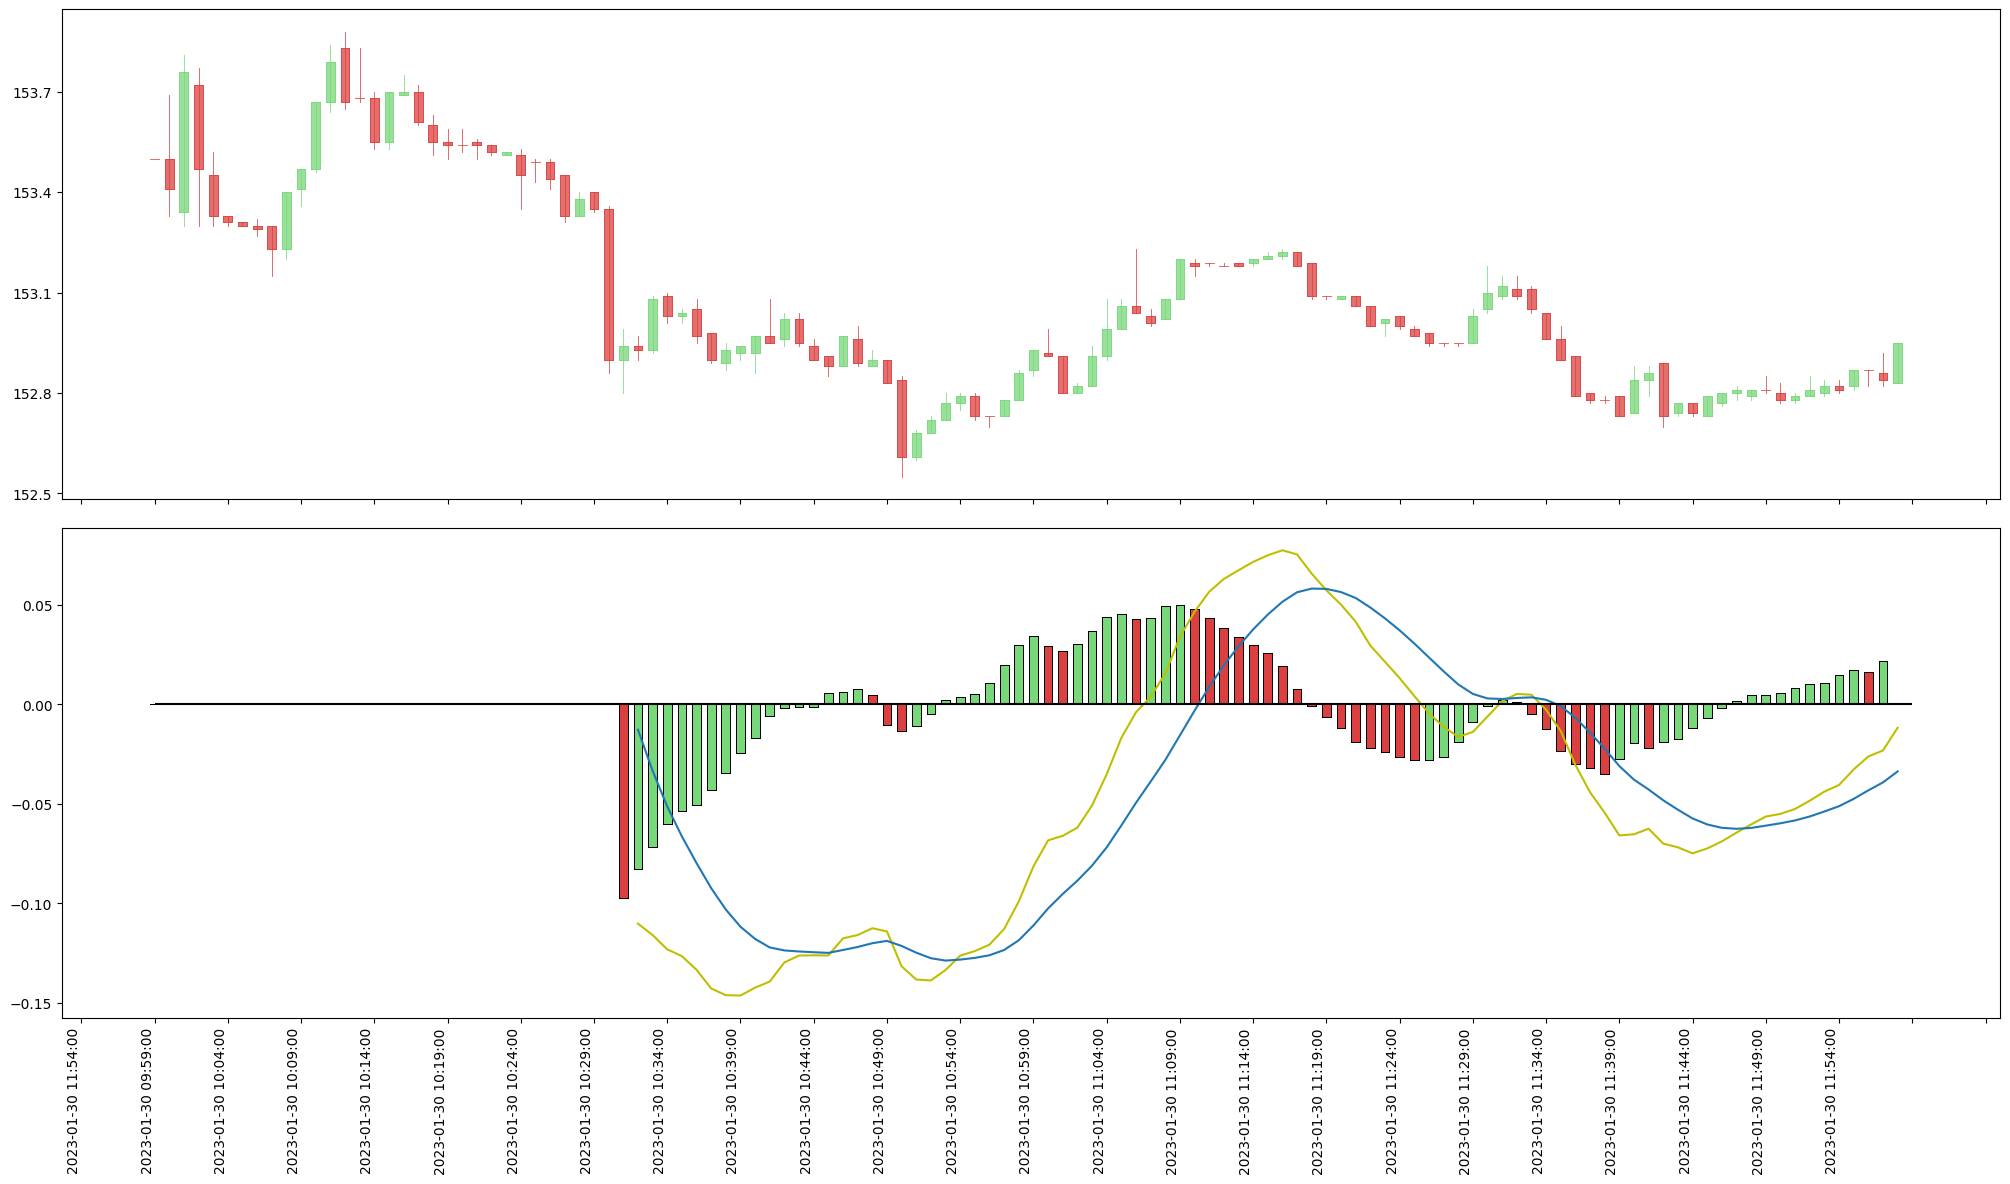

In [33]:
view.init_plot(2)
view.plot_candles()
view.plot_MACD()